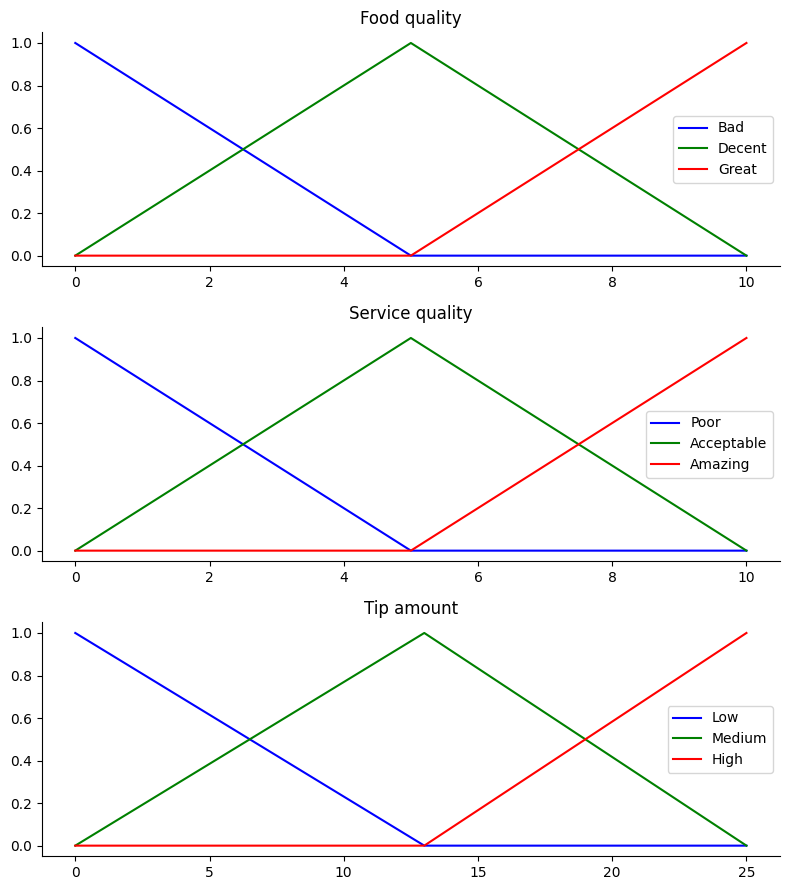

In [ ]:
!pip install -U scikit-fuzzy   # в первый запуск разкоментировать и нсталировать эту библиотеку

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

#Генерация переменных окружения:
x_qual = np.arange(0, 11, 1)  # качество еды, в диапазоне от 0 до 11 с шагом 1
x_serv = np.arange(0, 11, 1)  # качество обслуживания
x_tip  = np.arange(0, 26, 1)  # размер чаевых в % от суммы заказа

# ___ Проектирование функций принадлежности (membership function, MF) ___
# для качества еды
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])  # "низкое качество еды".  Первое число - начало основания.
qual_md = fuzz.trimf(x_qual, [0, 5, 10]) # "среднее качество еды". Второе - координата вершины треугольнка.
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])# "высокое качество еды". Третье - правая граница основания.
 # для качества обслуживания
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
# для размера чаевых
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

# Визуализация функций принадлежности
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

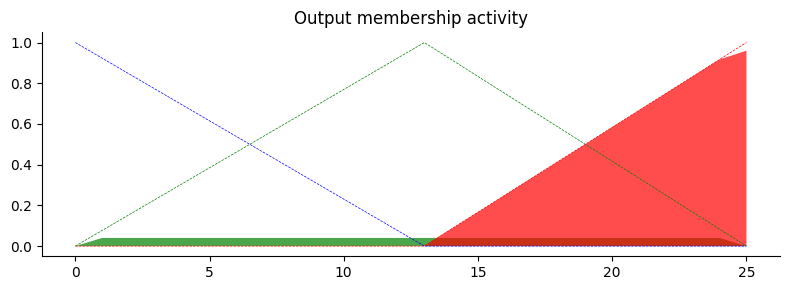

In [ ]:
# Какой будет уровень (level) чаевые при следующих входных данных: качество еды qual=6.5, обслуживание serv=9.8
# Для этого используем fuzz.interp_membership
# Сначала сразу вычислим значения MF для заданных величин входных переменных
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Теперь формируем правила и применяем их.
# Правило 1 (П1): "Если еда плохая ИЛИ обслуживание плохое, ТО чаевые маленькие"
# ИЛИ реализуется как взятие максимального из двух значений
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)  # фазификация для П1
tip_activation_lo = np.fmin(active_rule1, tip_lo)     # импликация для П1 - срезали MF tip_lo на уровне active_rule1

# Правило 2 (П2): "Если обслуживание среднее, ТО чаевые средние" - еда здесь не учитывается, мы так решили
tip_activation_md = np.fmin(serv_level_md, tip_md)  # срезали MF tip_md на уровне serv_level_md

# Правило 3 (П3): "Если обслуживание высокого качества ИЛИ еда высокого качества, ТО чаевые высокие
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi) # срезали MF tip_hiна уровне active_rule3
tip0 = np.zeros_like(x_tip)  # создали шаблон- масив 0 того же размера, что и x_tip - см. строка 10

# Визуализация срабатывания праил
fig, ax0 = plt.subplots(figsize=(8, 3))

# закрасить пространство между  y1=tip0 и  y2=tip_activation_lo по координатам x=x_tip
# для П1
ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
# для П2
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
# для П3
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Усеченные функции активации "чаевых" - выходы правил')

# Отключим верхнюю/правую рамки графиков
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

Размер чаевых рекомендуется, в % от суммы заказа:  19.86871794871795


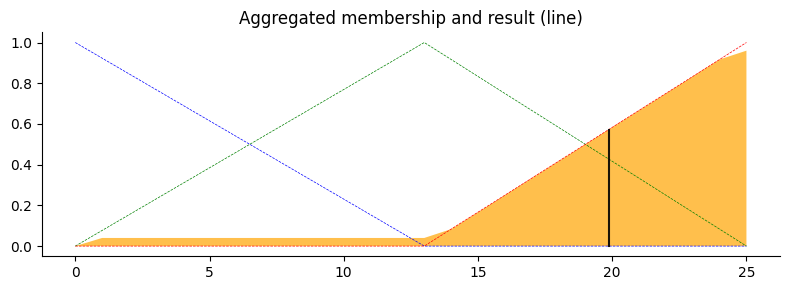

In [ ]:
# КОМПОЗИЦИЯ - объединяем все результирующие MF для чаевых (см. предыдущий график) вместе
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# ДЕФАЗИФИКАЦИЯ - центроидным методом вычисляем "четкое" значения для размера чаевых в %
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot
print('Размер чаевых рекомендуется, в % от суммы заказа: ',tip)

# Визуализация композиции
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Отключим верхнюю/правую рамки графиков
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()